## Siemens FDA

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
   - 5.1. Validating if there are partial or full missing values after the extraction
   - 5.2 Visualize the origin window intervals in different groups of Features
6. Additional Functions
   7.1. Visualization of plots with raw data after the extraction.
   7.2. Visualization of plots with data centered after the extraction.
7. Visualization of Time Series from the Windows
8. Functional PCA (Visualization of Principal Component Plots in one row)
    - 8.1. Functional PCA characterization function
    - 8.2 Functional PC1 plots (both systems)  Characterization of FPC Scores
    - 8.3 Linear Reregression
9. Fuctional regression
     

The improvements with respect to the code "Siemens_FDA.ipynb" are:
- Change the part in "Filtering and spliting in Bloods and Aqueous groups" for sample the data
- Change the "Merge data" Function in "Additional functions"
- Add 8.3 "Linear Regression" to make statistic summary for PCA(still developing)
- Update 7.2 function "plot_all_time_series_in_group" with a new function to save the photos

# 1. Loading the datasets

In [ ]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# # Import datasets
# sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
# sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
# sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
# sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
# sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
# sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
# keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# Import datasets
sensorA_System1 = pd.read_csv("../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("../../../RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("../../../RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("../../../RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
0,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor A,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
1,3550995,Eurotrol L1,2024-02-07 10:32:15,16-23333-20,302910,70,73,180.4,178.8,System 2A,Sensor B,21.2345,NaN,NaN,Success,NoError,NoError,Success,21.2345
2,3551012,Eurotrol L1,2024-02-07 10:41:33,16-23333-20,303096,70,73,183.2,181.6,System 2A,Sensor A,21.5012,NaN,NaN,Success,NoError,NoError,Success,21.5012


In [7]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})
keyByTestID.tail(3)

,TestID,FluidType,DateTime,Lot,CardNumber,AgeOfCardInDaysAtTimeOfTest,ReaderSerialNumber,SampleDetectTime,BubbleDetectTime,System,Sensor,AmbientTemperature,Fluid Temperature,CardReturnCode,ReturnCode,Results Error Code,Device Return Code,Bge Test ReturnCode,Fluid_Temperature_Filled
24255,3518677,HNB,2023-09-19 16:54:21,16-23151-20,302186,111,23,459.0,454.8,System 2,Sensor B,25.2250,15.0,NaN,Success,NoError,NoError,Success,15.0
24256,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor A,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0
24257,3518678,HNB,2023-09-19 16:54:23,16-23137-20,300820,125,33,459.2,455.2,System 2,Sensor B,24.4908,15.0,NaN,Success,NoError,NoError,Success,15.0


In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


In [9]:
# Remove the testID only exists in one sensor
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


# 4. Window extraction

In [21]:
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows based on given start points and delimiters.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start, 1), round(cal_window_end, 1), round(sample_window_start, 1), round(sample_window_end, 1)

def calculate_window_data(row):
    """
    Extract calibration and sample window data from a given row of time series data.

    Parameters:
    -----------
    row : pd.Series
        A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -5 should contain the timestamps (as float) of the time series data.

    Returns:
    --------
    tuple of pd.Series
        A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-5].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window], row[sample_window]

def process_sensor_data(merged_df, calDelimit, cal_window_size, sampleDelimit, sample_window_size, sampleDelimit_aqueous=None):
    """
    Process sensor data by calculating window values and extracting window data for each test.

    Parameters:
    -----------
    merged_df : pd.DataFrame
        The merged DataFrame containing sensor data and time series information.
    calDelimit : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size : float
        The size of the calibration window.
    sampleDelimit : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size : float
        The size of the sample window.
    sampleDelimit_aqueous : float, optional
        The delimiter value to adjust the starting point of the sample window for aqueous samples (default is None).

    Returns:
    --------
    tuple of pd.DataFrame
        A tuple containing two DataFrames:
        - The first DataFrame corresponds to the calibration window data for each test.
        - The second DataFrame corresponds to the sample window data for each test.
    """
    # Calculate window values
    if sampleDelimit_aqueous != None:
        merged_df['cal_window_start'], merged_df['cal_window_end'], \
        merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
            lambda row: calculate_window_values(
                bubble_start=row['BubbleDetectTime'],
                sample_start=row['SampleDetectTime'],
                calDelimit_input=calDelimit,
                cal_window_size_input=cal_window_size,
                sampleDelimit_input=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit,
                sample_window_size_input=sample_window_size
            ), axis=1))
    else:
        merged_df['cal_window_start'], merged_df['cal_window_end'], \
        merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
            lambda row: calculate_window_values(
                bubble_start=row['BubbleDetectTime'],
                sample_start=row['SampleDetectTime'],
                calDelimit_input=calDelimit,
                cal_window_size_input=cal_window_size,
                sampleDelimit_input=sampleDelimit,
                sample_window_size_input=sample_window_size
            ), axis=1))

    # Extract window data
    cal_window_list = []
    sample_window_list = []
    for i in range(len(merged_df)):
        cal_window, sample_window = calculate_window_data(merged_df.iloc[i, :])
        cal_window_list.append(cal_window.values)
        sample_window_list.append(sample_window.values)

    cal_window_df = pd.DataFrame(cal_window_list)
    sample_window_df = pd.DataFrame(sample_window_list)
    cal_window_df['TestID'] = sample_window_df['TestID'] = merged_df['TestID'].astype(int)
    sample_window_df.set_index('TestID', inplace=True)
    cal_window_df.set_index('TestID', inplace=True)

    return cal_window_df, sample_window_df


In [60]:
# Usage for System 1 and System 2 for Sensors A and B
calDelimit_A = 11
cal_window_size_A = 8
sampleDelimit_A = 15
sample_window_size_A = 5

calDelimit_B = 20
cal_window_size_B = 18
sampleDelimit_B_blood = 24
sampleDelimit_B_aqueous = 30
sample_window_size_B = 4

B1_Merged_blood = B1_Merged[~B1_Merged['FluidType'].str.startswith('Eurotrol')]
B1_Merged_aqueous = B1_Merged[B1_Merged['FluidType'].str.startswith('Eurotrol')]
B2_Merged_blood = B2_Merged[~B2_Merged['FluidType'].str.startswith('Eurotrol')]
B2_Merged_aqueous = B2_Merged[B2_Merged['FluidType'].str.startswith('Eurotrol')]

A1_cal_window, A1_sample_window = process_sensor_data(A1_Merged, calDelimit_A, cal_window_size_A, sampleDelimit_A, sample_window_size_A)
A2_cal_window, A2_sample_window = process_sensor_data(A2_Merged, calDelimit_A, cal_window_size_A, sampleDelimit_A, sample_window_size_A)

B1_cal_window, B1_sample_window = process_sensor_data(B1_Merged, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)
B2_cal_window, B2_sample_window = process_sensor_data(B2_Merged, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)

B1_cal_window_blood, B1_sample_window_blood = process_sensor_data(B1_Merged_blood, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B)
B2_cal_window_blood, B2_sample_window_blood = process_sensor_data(B2_Merged_blood, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B)

B1_cal_window_aqueous, B1_sample_window_aqueous = process_sensor_data(B1_Merged_aqueous, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)
B2_cal_window_aqueous, B2_sample_window_aqueous = process_sensor_data(B2_Merged_aqueous, calDelimit_B, cal_window_size_B, sampleDelimit_B_blood, sample_window_size_B, sampleDelimit_B_aqueous)

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cal_window_start'], merged_df['cal_window_end'], \
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:105: SettingWithCopyWarning:

# 5. Slope Calculation and Window Optimization

In [39]:
from sklearn.linear_model import LinearRegression

def calculate_column_means(df1, df2):
    """
    Calculate the column means of two DataFrames.

    Parameters:
    -----------
    df1 : pd.DataFrame
        The first DataFrame.
    df2 : pd.DataFrame
        The second DataFrame.

    Returns:
    --------
    tuple of pd.Series
        A tuple containing two Series:
        - The first Series corresponds to the column means of the first DataFrame.
        - The second Series corresponds to the column means of the second DataFrame.
    """
    mean_df1 = df1.mean(axis=0)
    mean_df2 = df2.mean(axis=0)
    return mean_df1, mean_df2

def calculate_slope(column_means):
    """
    Calculate the slope using Simple Linear Regression (SLR) on the given column means.

    Parameters:
    -----------
    column_means : pd.Series
        A Series containing the column means.

    Returns:
    --------
    float
        The slope calculated using SLR.
    """
    # Drop NaN values
    column_means = column_means.dropna()

    # Check if column_means is empty after dropping NaNs
    if column_means.empty:
        return np.nan

    x = np.arange(len(column_means)).reshape(-1, 1)
    y = column_means.values
    reg = LinearRegression().fit(x, y)
    return reg.coef_[0]

def difference_of_slopes(df1, df2):
    """
    Calculate the difference between the slopes of two DataFrames based on their column means using SLR.

    Parameters:
    -----------
    df1 : pd.DataFrame
        The first DataFrame.
    df2 : pd.DataFrame
        The second DataFrame.

    Returns:
    --------
    float
        The difference between the slopes calculated using SLR on the column means of the two DataFrames.
    """
    mean_df1, mean_df2 = calculate_column_means(df1, df2)
    slope1 = calculate_slope(mean_df1)
    slope2 = calculate_slope(mean_df2)
    return slope1 - slope2


## 5.1. Sensor A

In [40]:
diff_slopes_result_A = {}
for delimit in range(100):
    A2_cal_window_new, A2_sample_window_new = process_sensor_data(A2_Merged, delimit, cal_window_size_A, delimit, sample_window_size_A)
    diff_slopes_cal = difference_of_slopes(A1_cal_window, A2_cal_window_new)
    diff_slopes_sample = difference_of_slopes(A1_sample_window, A2_sample_window_new)
    diff_slopes_result_A[delimit] = {
        'diff_slopes_cal': diff_slopes_cal,
        'diff_slopes_sample': diff_slopes_sample
    }

In [41]:
print(pd.DataFrame(diff_slopes_result_A))

                          0         1         2         3         4   \
diff_slopes_cal     0.486548  0.286391  0.094627 -0.084304 -0.245094   
diff_slopes_sample  0.247431  0.150482  0.099433  0.068295  0.046519   

                          5         6         7         8         9   ...  \
diff_slopes_cal    -0.373319 -0.439789 -0.333621  0.003467  0.003412  ...   
diff_slopes_sample  0.030143  0.017598  0.008163  0.001380 -0.003176  ...   

                          90        91        92        93        94  \
diff_slopes_cal     0.070235  0.078028  0.086866  0.096598  0.107036   
diff_slopes_sample       NaN       NaN       NaN       NaN       NaN   

                          95       96       97        98        99  
diff_slopes_cal     0.117932  0.12902  0.14009  0.151025  0.161802  
diff_slopes_sample       NaN      NaN      NaN       NaN       NaN  

[2 rows x 100 columns]


In [50]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_cal = float('inf')
min_abs_diff_slopes_sample = float('inf')
min_abs_diff_slopes_cal_key = None
min_abs_diff_slopes_sample_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_A.items():
    abs_diff_slopes_cal = abs(result['diff_slopes_cal'])
    abs_diff_slopes_sample = abs(result['diff_slopes_sample'])
    
    if abs_diff_slopes_cal < min_abs_diff_slopes_cal:
        min_abs_diff_slopes_cal = abs_diff_slopes_cal
        min_abs_diff_slopes_cal_key = key
    
    if abs_diff_slopes_sample < min_abs_diff_slopes_sample:
        min_abs_diff_slopes_sample = abs_diff_slopes_sample
        min_abs_diff_slopes_sample_key = key

# Print the results
print(f"Absolute minimum value of diff_slopes_cal: {min_abs_diff_slopes_cal} (Key: {min_abs_diff_slopes_cal_key})")
print(f"Absolute minimum value of diff_slopes_sample: {min_abs_diff_slopes_sample} (Key: {min_abs_diff_slopes_sample_key})")


Absolute minimum value of diff_slopes_cal: 0.003246243723518571 (Key: 10)
Absolute minimum value of diff_slopes_sample: 0.0008991122747031965 (Key: 59)


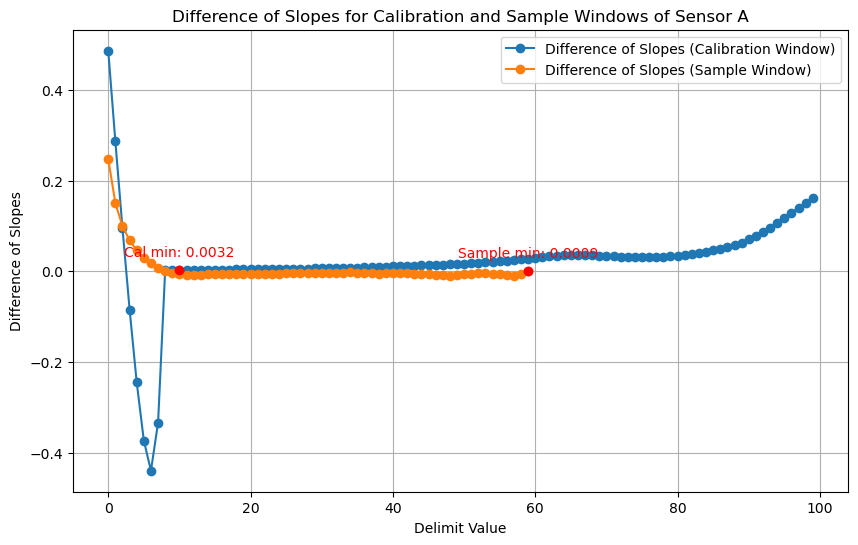

In [46]:
# Extract delimit values and corresponding differences in slopes
delimits = list(diff_slopes_result_A.keys())
diff_slopes_cal = [diff_slopes_result_A[delimit]['diff_slopes_cal'] for delimit in delimits]
diff_slopes_sample = [diff_slopes_result_A[delimit]['diff_slopes_sample'] for delimit in delimits]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_cal
plt.plot(delimits, diff_slopes_cal, label='Difference of Slopes (Calibration Window)', marker='o')

# Plot diff_slopes_sample
plt.plot(delimits, diff_slopes_sample, label='Difference of Slopes (Sample Window)', marker='o')

# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_cal_key, diff_slopes_result_A[min_abs_diff_slopes_cal_key]['diff_slopes_cal'],
            color='red', zorder=5)
plt.scatter(min_abs_diff_slopes_sample_key, diff_slopes_result_A[min_abs_diff_slopes_sample_key]['diff_slopes_sample'],
            color='red', zorder=5)

# Annotate the points with minimum values
plt.annotate(f'Cal min: {diff_slopes_result_A[min_abs_diff_slopes_cal_key]["diff_slopes_cal"]:.4f}',
             (min_abs_diff_slopes_cal_key, diff_slopes_result_A[min_abs_diff_slopes_cal_key]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.annotate(f'Sample min: {diff_slopes_result_A[min_abs_diff_slopes_sample_key]["diff_slopes_sample"]:.4f}',
             (min_abs_diff_slopes_sample_key, diff_slopes_result_A[min_abs_diff_slopes_sample_key]['diff_slopes_sample']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')

# Adding title and labels
plt.title('Difference of Slopes for Calibration and Sample Windows of Sensor A')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


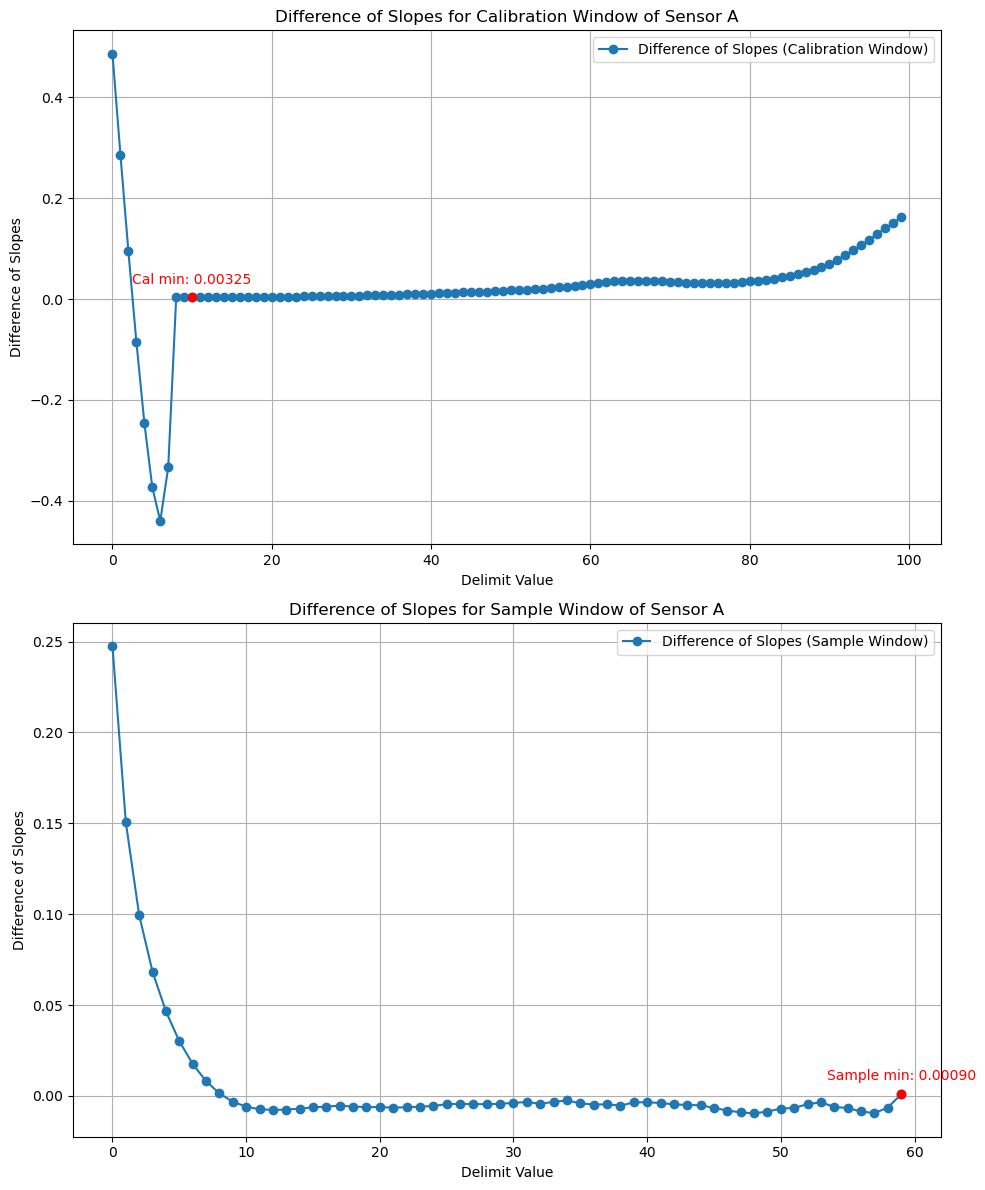

In [49]:
# Extract delimit values and corresponding differences in slopes
delimits = list(diff_slopes_result_A.keys())
diff_slopes_cal = [diff_slopes_result_A[delimit]['diff_slopes_cal'] for delimit in delimits]
diff_slopes_sample = [diff_slopes_result_A[delimit]['diff_slopes_sample'] for delimit in delimits]


# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot diff_slopes_cal
ax1.plot(delimits, diff_slopes_cal, label='Difference of Slopes (Calibration Window)', marker='o')
ax1.scatter(min_abs_diff_slopes_cal_key, diff_slopes_result_A[min_abs_diff_slopes_cal_key]['diff_slopes_cal'],
            color='red', zorder=5)
ax1.annotate(f'Cal min: {diff_slopes_result_A[min_abs_diff_slopes_cal_key]["diff_slopes_cal"]:.5f}',
             (min_abs_diff_slopes_cal_key, diff_slopes_result_A[min_abs_diff_slopes_cal_key]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
ax1.set_title('Difference of Slopes for Calibration Window of Sensor A')
ax1.set_xlabel('Delimit Value')
ax1.set_ylabel('Difference of Slopes')
ax1.legend()
ax1.grid(True)

# Plot diff_slopes_sample
ax2.plot(delimits, diff_slopes_sample, label='Difference of Slopes (Sample Window)', marker='o')
ax2.scatter(min_abs_diff_slopes_sample_key, diff_slopes_result_A[min_abs_diff_slopes_sample_key]['diff_slopes_sample'],
            color='red', zorder=5)
ax2.annotate(f'Sample min: {diff_slopes_result_A[min_abs_diff_slopes_sample_key]["diff_slopes_sample"]:.5f}',
             (min_abs_diff_slopes_sample_key, diff_slopes_result_A[min_abs_diff_slopes_sample_key]['diff_slopes_sample']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
ax2.set_title('Difference of Slopes for Sample Window of Sensor A')
ax2.set_xlabel('Delimit Value')
ax2.set_ylabel('Difference of Slopes')
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


## 5.2. Sensor B

### 5.2.1. Sensor B - Cal window

In [71]:
diff_slopes_result_B_cal = {}
for delimit in range(100):
    B2_cal_window_new, _ = process_sensor_data(B2_Merged, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    diff_slopes_cal = difference_of_slopes(B1_cal_window, B2_cal_window_new)
    diff_slopes_result_B_cal[delimit] = {
        'diff_slopes_cal': diff_slopes_cal,
    }

In [72]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_cal = float('inf')
min_abs_diff_slopes_cal_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_B_cal.items():
    abs_diff_slopes_cal = abs(result['diff_slopes_cal'])
    
    if abs_diff_slopes_cal < min_abs_diff_slopes_cal:
        min_abs_diff_slopes_cal = abs_diff_slopes_cal
        min_abs_diff_slopes_cal_key = key
    

# Print the results
print(f"Absolute minimum value of diff_slopes_cal: {min_abs_diff_slopes_cal} (Key: {min_abs_diff_slopes_cal_key})")


Absolute minimum value of diff_slopes_cal: 0.003347377677299576 (Key: 98)


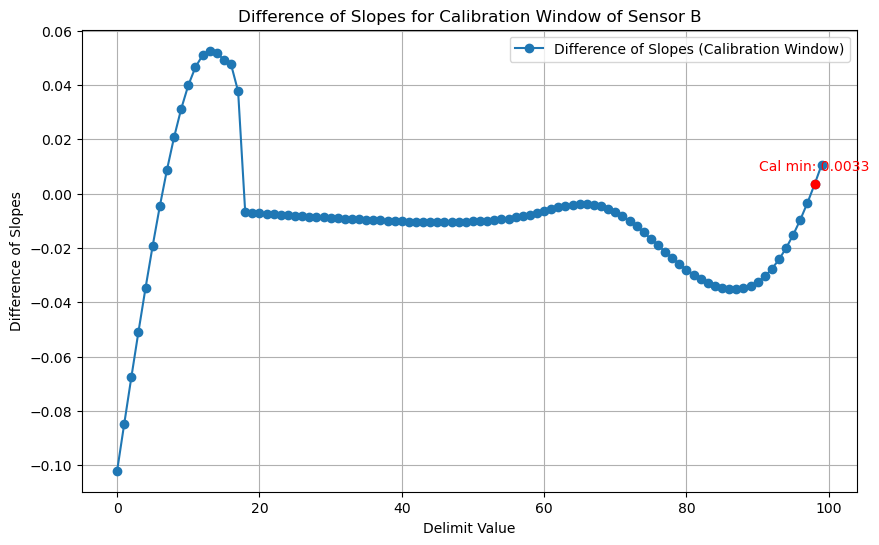

In [74]:
# Extract delimit values and corresponding differences in slopes
delimits = list(diff_slopes_result_B_cal.keys())
diff_slopes_cal = [diff_slopes_result_B_cal[delimit]['diff_slopes_cal'] for delimit in delimits]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_cal
plt.plot(delimits, diff_slopes_cal, label='Difference of Slopes (Calibration Window)', marker='o')


# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_cal_key, diff_slopes_result_B_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal'],
            color='red', zorder=5)

# Annotate the points with minimum values
plt.annotate(f'Cal min: {diff_slopes_result_B_cal[min_abs_diff_slopes_cal_key]["diff_slopes_cal"]:.4f}',
             (min_abs_diff_slopes_cal_key, diff_slopes_result_B_cal[min_abs_diff_slopes_cal_key]['diff_slopes_cal']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')


# Adding title and labels
plt.title('Difference of Slopes for Calibration Window of Sensor B')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


### 5.2.2. Sensor B - Sample window

In [75]:
diff_slopes_result_B_sample = {}
for delimit in range(100):
    _, B2_sample_window_blood_new = process_sensor_data(B2_Merged_blood, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    _, B2_sample_window_aqueous_new = process_sensor_data(B2_Merged_aqueous, delimit, cal_window_size_B, delimit, sample_window_size_B, delimit)
    diff_slopes_sample_blood = difference_of_slopes(B1_sample_window_blood, B2_sample_window_blood_new)
    diff_slopes_sample_aqueous = difference_of_slopes(B1_sample_window_aqueous, B2_sample_window_aqueous_new)
    diff_slopes_result_B_sample[delimit] = {
        'diff_slopes_sample_blood': diff_slopes_sample_blood,
        'diff_slopes_sample_aqueous': diff_slopes_sample_aqueous
    }

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cal_window_start'], merged_df['cal_window_end'], \
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['sample_window_start'], merged_df['sample_window_end'] = zip(*merged_df.apply(
/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_46272/97189566.py:94: SettingWithCopyWarning: 
A

In [76]:
# Initialize variables to store the minimum absolute values and corresponding keys
min_abs_diff_slopes_sample_blood = float('inf')
min_abs_diff_slopes_sample_aqueous = float('inf')
min_abs_diff_slopes_sample_blood_key = None
min_abs_diff_slopes_sample_aqueous_key = None

# Iterate through the dictionary to find the absolute minimum values and their keys
for key, result in diff_slopes_result_B_sample.items():
    abs_diff_slopes_sample_blood = abs(result['diff_slopes_sample_blood'])
    abs_diff_slopes_sample_aqueous = abs(result['diff_slopes_sample_aqueous'])
    
    if abs_diff_slopes_sample_blood < min_abs_diff_slopes_sample_blood:
        min_abs_diff_slopes_sample_blood = abs_diff_slopes_sample_blood
        min_abs_diff_slopes_sample_blood_key = key
    
    if abs_diff_slopes_sample_aqueous < min_abs_diff_slopes_sample_aqueous:
        min_abs_diff_slopes_sample_aqueous = abs_diff_slopes_sample_aqueous
        min_abs_diff_slopes_sample_aqueous_key = key

# Print the results
print(f"Absolute minimum value of diff_slopes_sample_blood: {min_abs_diff_slopes_sample_blood} (Key: {min_abs_diff_slopes_sample_blood_key})")
print(f"Absolute minimum value of diff_slopes_sample_aqueous: {min_abs_diff_slopes_sample_aqueous} (Key: {min_abs_diff_slopes_sample_aqueous_key})")

Absolute minimum value of diff_slopes_sample_blood: 0.0003956198275427633 (Key: 33)
Absolute minimum value of diff_slopes_sample_aqueous: 0.0011199363016880376 (Key: 59)


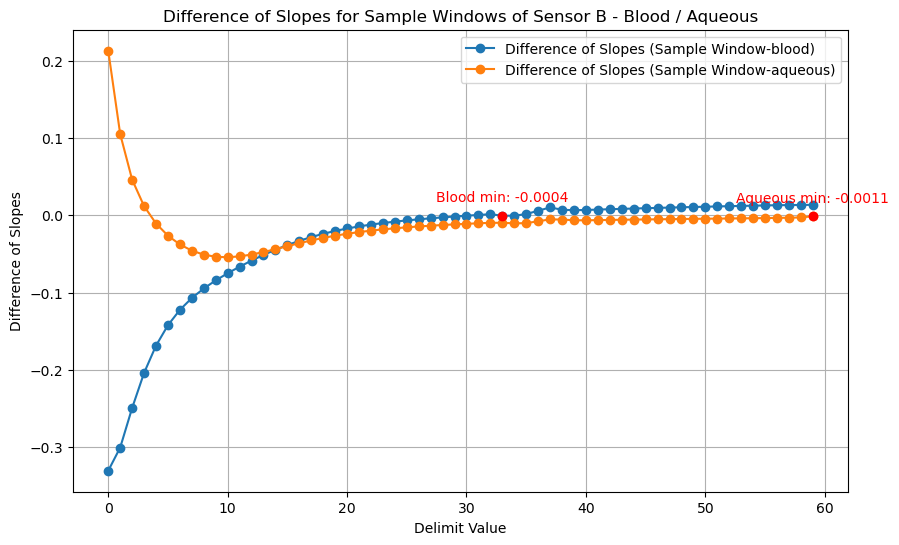

In [78]:
# Extract delimit values and corresponding differences in slopes
delimits = list(diff_slopes_result_B_sample.keys())
diff_slopes_blood = [diff_slopes_result_B_sample[delimit]['diff_slopes_sample_blood'] for delimit in delimits]
diff_slopes_aqueous = [diff_slopes_result_B_sample[delimit]['diff_slopes_sample_aqueous'] for delimit in delimits]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot diff_slopes_blood
plt.plot(delimits, diff_slopes_blood, label='Difference of Slopes (Sample Window-blood)', marker='o')

# Plot diff_slopes_aqueous
plt.plot(delimits, diff_slopes_aqueous, label='Difference of Slopes (Sample Window-aqueous)', marker='o')

# Mark the minimum absolute values
plt.scatter(min_abs_diff_slopes_sample_blood_key, diff_slopes_result_B_sample[min_abs_diff_slopes_sample_blood_key]['diff_slopes_sample_blood'],
            color='red', zorder=5)
plt.scatter(min_abs_diff_slopes_sample_aqueous_key, diff_slopes_result_B_sample[min_abs_diff_slopes_sample_aqueous_key]['diff_slopes_sample_aqueous'],
            color='red', zorder=5)

# Annotate the points with minimum values
plt.annotate(f'Blood min: {diff_slopes_result_B_sample[min_abs_diff_slopes_sample_blood_key]["diff_slopes_sample_blood"]:.4f}',
             (min_abs_diff_slopes_sample_blood_key, diff_slopes_result_B_sample[min_abs_diff_slopes_sample_blood_key]['diff_slopes_sample_blood']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')
plt.annotate(f'Aqueous min: {diff_slopes_result_B_sample[min_abs_diff_slopes_sample_aqueous_key]["diff_slopes_sample_aqueous"]:.4f}',
             (min_abs_diff_slopes_sample_aqueous_key, diff_slopes_result_B_sample[min_abs_diff_slopes_sample_aqueous_key]['diff_slopes_sample_aqueous']),
             textcoords="offset points", xytext=(0,10), ha='center', color='red')

# Adding title and labels
plt.title('Difference of Slopes for Sample Windows of Sensor B - Blood / Aqueous')
plt.xlabel('Delimit Value')
plt.ylabel('Difference of Slopes')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


## 5.3. Validating if there are partial or full missing values after the extraction

In [12]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

B1_cal_window_drop_index = B1_cal_window.loc[B1_cal_window.isna().sum(axis=1)!=0].index
B2_cal_window_drop_index = B2_cal_window.loc[B2_cal_window.isna().sum(axis=1)!=0].index

B1_sample_window_drop_index = B1_sample_window.loc[B1_sample_window.isna().sum(axis=1)!=0].index
B2_sample_window_drop_index = B2_sample_window.loc[B2_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_cal_window_drop_index)
print("The missing value in sample window:",B1_sample_window_drop_index)
print("The missing value in calibration window:",B2_cal_window_drop_index)
print("The missing value in sample window:",B2_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')


In [13]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_cal_window: ', A1_cal_window.shape)
print('A2_cal_window: ', A2_cal_window.shape)
print('B1_cal_window: ', B1_cal_window.shape)
print('B2_cal_window: ', B2_cal_window.shape)

# Sample Window
print('A1_sample_window: ', A1_sample_window.shape)
print('A2_sample_window: ', A2_sample_window.shape)
print('B1_sample_window: ', B1_sample_window.shape)
print('B2_sample_window: ', B2_sample_window.shape)

Shape of the time series after extraction
A1_cal_window:  (3374, 41)
A2_cal_window:  (7743, 41)
B1_cal_window:  (3374, 91)
B2_cal_window:  (7743, 91)
A1_sample_window:  (3374, 26)
A2_sample_window:  (7743, 26)
B1_sample_window:  (3374, 21)
B2_sample_window:  (7743, 21)
